# Pretrained CNN + Encoder-Decoder

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from __future__ import print_function, division

import os
import sys

# NOTE: Inferring the project root path like this will not always work
# (e.g. when the notebook resides on a different server to the kernel)
# Set the path directly if necessary.
root_path = os.path.dirname(os.getcwd())
sys.path.append(root_path)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import time
import copy
import glob
from PIL import Image


from imednet.models.encoder_decoder import CNNEncoderDecoderNet, TrainingParameters
from imednet.data.mat_loader import MatLoader
from imednet.trainers.encoder_decoder_trainer import Trainer

plt.ion()   # interactive mode

## Parameters

In [2]:
data_path = os.path.join(root_path, 'data/slike_780.4251')
model_load_path = os.path.join(root_path, 'models/cnn_encoder_decoder/Model 2018-07-09 19:49:39.649210')
cnn_model_load_path = os.path.join(root_path, 'models/mnist_cnn/mnist_cnn.model')

## Load Data

In [3]:
# Load data and scale it
images, outputs, scale, or_tr = MatLoader.load_data(data_path)

## Load Model

In [4]:
# Set up DMP parameters
N = 25
sampling_time = 0.1

# Define layer sizes
input_size = 1600
hidden_layer_sizes = [20, 35]
output_size = 2*N + 4
layer_sizes = [input_size] + hidden_layer_sizes + [output_size]

In [5]:
# Load the model
model = CNNEncoderDecoderNet(cnn_model_load_path, layer_sizes, scale)

In [6]:
# Initialize the model
net_params_path = os.path.join(model_load_path, 'net_parameters')
model.load_state_dict(torch.load(net_params_path))

## Test on Synthetic Digit Images

Note that the current version of this randomly selects samples from the ENTIRE dataset (including training, validation and test sets).  TODO: fix this later.

In [7]:
torch_images = torch.autograd.Variable(torch.from_numpy(images)).float()
torch_outputs = torch.autograd.Variable(torch.from_numpy(outputs)).float()

In [8]:
torch_predicted_outputs = model(torch_images)

In [9]:
trainer = Trainer()

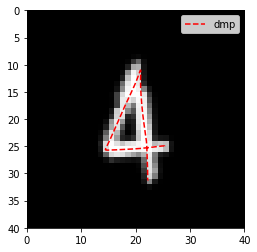

In [10]:
i_sample = np.random.randint(outputs.shape[0])
sample_output_dmp = trainer.create_dmp(torch_outputs[i_sample,:], model.scale, 0.01, 25, True)
torch_sample_predicted_output = torch.cat((torch.tensor([-1.]), torch_predicted_outputs[i_sample,:]), 0)
sample_predicted_output_dmp = trainer.create_dmp(torch_sample_predicted_output, model.scale, 0.01, 25, True)
sample_output_dmp.joint()
# mat = trainer.show_dmp(images[i_sample,:], sample_output_dmp.Y, sample_predicted_output_dmp, plot=False)
mat = trainer.show_dmp(images[i_sample,:], None, sample_predicted_output_dmp, plot=False)

## Transfer to Unseen MNIST Digit Images

In [22]:
import mnist
from mnist import MNIST
mndata = MNIST(os.path.join(root_path, 'data/mnist'))
mnist_images, mnist_labels = mndata.load_training()
mnist_images = np.asarray(mnist_images)
mnist_images.shape

(60000, 784)

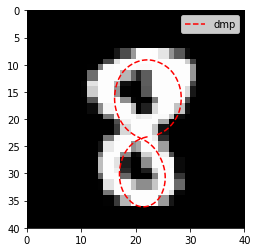

In [18]:
i_sample = np.random.randint(mnist_images.shape[0])
mnist_sample = mnist_images[i_sample,:].reshape(28,28)
pil_mnist_sample = Image.fromarray(np.uint8(mnist_sample))
pil_scaled_mnist_sample = pil_mnist_sample.resize((40,40))
scaled_mnist_sample = np.array(pil_scaled_mnist_sample).reshape(1,40*40)
scaled_mnist_sample = scaled_mnist_sample / np.max(scaled_mnist_sample)
torch_scaled_mnist_sample = torch.autograd.Variable(torch.from_numpy(scaled_mnist_sample)).float()
torch_scaled_mnist_sample_predicted_output = model(torch_scaled_mnist_sample)
torch_scaled_mnist_sample_predicted_output = torch.cat((torch.tensor([-1.]), torch_scaled_mnist_sample_predicted_output[0,:]), 0)
scaled_mnist_sample_predicted_output_dmp = trainer.create_dmp(torch_scaled_mnist_sample_predicted_output, model.scale, 0.01, 25, True)
scaled_mnist_sample_predicted_output_dmp.joint()
mat = trainer.show_dmp(scaled_mnist_sample, None, scaled_mnist_sample_predicted_output_dmp, plot=False)